In [125]:
import torch as tc 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from torch.utils.data import DataLoader,TensorDataset
from torch import nn,optim 
from torchmetrics import Accuracy
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

In [126]:
cycling=pd.read_csv("/home/ahmadreza/git/rep4/Cycling.csv").drop('YYYY-MO-DD HH-MI-SS_SSS',axis=1)
football=pd.read_csv('/home/ahmadreza/git/rep4/Football.csv').drop('YYYY-MO-DD HH-MI-SS_SSS',axis=1)
jogging=pd.read_csv('/home/ahmadreza/git/rep4/Jogging.csv').drop('YYYY-MO-DD HH-MI-SS_SSS',axis=1)
jump_rope=pd.read_csv('/home/ahmadreza/git/rep4/JumpRope.csv').drop('YYYY-MO-DD HH-MI-SS_SSS',axis=1)
push_ups=pd.read_csv('/home/ahmadreza/git/rep4/Pushups.csv').drop('YYYY-MO-DD HH-MI-SS_SSS',axis=1)
sitting=pd.read_csv('/home/ahmadreza/git/rep4/Sitting.csv').drop('YYYY-MO-DD HH-MI-SS_SSS',axis=1)
swimming=pd.read_csv('/home/ahmadreza/git/rep4/Swimming.csv').drop('YYYY-MO-DD HH-MI-SS_SSS',axis=1)
tennis=pd.read_csv('/home/ahmadreza/git/rep4/Tennis.csv').drop('YYYY-MO-DD HH-MI-SS_SSS',axis=1)
walking=pd.read_csv('/home/ahmadreza/git/rep4/Walking.csv').drop('YYYY-MO-DD HH-MI-SS_SSS',axis=1)
walking_down_stairs=pd.read_csv('/home/ahmadreza/git/rep4/WalkingDownstairs.csv').drop('YYYY-MO-DD HH-MI-SS_SSS',axis=1)
walking_up_stairs=pd.read_csv('/home/ahmadreza/git/rep4/WalkingUpstairs.csv').drop('YYYY-MO-DD HH-MI-SS_SSS',axis=1)

cycling['target']=[0]*cycling.shape[0]
football['target']=[1]*football.shape[0]
jogging['target']=[2]*jogging.shape[0]
jump_rope['target']=[3]*jump_rope.shape[0]
push_ups['target']=[4]*push_ups.shape[0]
sitting['target']=[5]*sitting.shape[0]
swimming['target']=[6]*swimming.shape[0]
tennis['target']=[7]*tennis.shape[0]
walking['target']=[8]*walking.shape[0]
walking_down_stairs['target']=[9]*walking_down_stairs.shape[0]
walking_up_stairs['target']=[10]*walking_up_stairs.shape[0]

tennis.columns=football.columns

In [127]:
data=pd.concat([cycling,football,jogging,jump_rope,push_ups,sitting,swimming,tennis,walking,walking_down_stairs,walking_up_stairs])

In [128]:
x=data.drop('target',axis=1)
y=data.target

In [129]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.1,random_state=42)
xtrain,xvalid,ytrain,yvalid=train_test_split(xtrain,ytrain,train_size=7/9)

In [130]:
xtrain=tc.FloatTensor(xtrain.values)
ytrain=tc.LongTensor(ytrain.values)

xvalid=tc.FloatTensor(xvalid.values)
yvalid=tc.LongTensor(yvalid.values)

xtest=tc.FloatTensor(xtest.values)
ytest=tc.LongTensor(ytest.values)

In [131]:
mean=xtrain.mean(dim=0)
std=xtrain.std(dim=0)

In [132]:
xtrain=(xtrain-mean)/std
xvalid=(xvalid-mean)/std
xtest=(xtest-mean)/std

In [133]:
train_dataset=TensorDataset(xtrain,ytrain)
valid_dataset=TensorDataset(xvalid,yvalid)

In [134]:
train_loader=DataLoader(train_dataset,batch_size=256,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=512,shuffle=False)

In [135]:
device='cuda' if tc.cuda.is_available() else 'cpu'

In [136]:
model=nn.Sequential(nn.Linear(xtrain.shape[1],64),nn.ReLU(),nn.Linear(64,32),nn.ReLU(),nn.Linear(32,16),nn.ReLU(),nn.Linear(16,11)).to(device)

In [137]:
loss_func=nn.CrossEntropyLoss()

In [138]:
def optimize(type=str):
  if type=='adam':
    optimizer=optim.Adam(model.parameters(),lr=0.001,betas=[0.9,0.99],eps=10.e-9)
  elif type=='sgd':
    optimizer=optim.SGD(model.parameters(),lr=0.01)
  elif type=='sgd-m':
    optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9,nesterov=False)
  elif type=='sgd-nest':
    optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9,nesterov=True)
  elif type=='rms':
    optimizer=optim.RMSprop(model.parameters(),lr=0.0001,alpha=0.99,eps=10.e-9)
  return optimizer

In [139]:
optimizer_name='adam'
optimizer=optimize(optimizer_name)

In [140]:
N=200

acc_train_hist,acc_valid_hist=[],[]
loss_train_hist,loss_valid_hist=[],[]

for i in range(N):

    train_loss,valid_loss=0,0

    acc_train=Accuracy(task='multiclass',num_classes=11).to(device)
    acc_valid=Accuracy(task='multiclass',num_classes=11).to(device)

    for j,(x,y) in enumerate(train_loader):
        x=x.to(device)
        y=y.to(device)
        yp=model(x)
        loss=loss_func(yp.squeeze(),y)
        train_loss+=loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        acc_train(yp,y)

    train_loss=train_loss/(j+1)

    for j,(x,y) in enumerate(valid_loader):
        x=x.to(device)
        y=y.to(device)
        yp=model(x)
        loss=loss_func(yp.squeeze(),y)
        valid_loss+=loss.detach()
        acc_valid(yp,y)

    valid_loss=valid_loss/(j+1)

    acc_train_hist.append(acc_train.compute().cpu())
    acc_valid_hist.append(acc_valid.compute().cpu())
    loss_train_hist.append(train_loss.cpu())
    loss_valid_hist.append(valid_loss.cpu())

    if (i+1)%5==0:
        print(f'Epoch={i+1}')
        print(f'train loss={train_loss:.4},accuracy={acc_train.compute():.4}')
        print(f'valid loss={valid_loss:.4},accuracy={acc_valid.compute():.4}')
        print()

Epoch=5
train loss=0.5691,accuracy=0.7983
valid loss=0.5665,accuracy=0.8002

Epoch=10
train loss=0.4726,accuracy=0.8333
valid loss=0.4849,accuracy=0.8293

Epoch=15
train loss=0.4283,accuracy=0.8483
valid loss=0.4417,accuracy=0.8417

Epoch=20
train loss=0.3961,accuracy=0.8581
valid loss=0.4185,accuracy=0.8504

Epoch=25
train loss=0.3765,accuracy=0.8649
valid loss=0.3976,accuracy=0.8625

Epoch=30
train loss=0.3581,accuracy=0.8719
valid loss=0.3844,accuracy=0.8653

Epoch=35
train loss=0.3452,accuracy=0.8764
valid loss=0.3731,accuracy=0.8697

Epoch=40
train loss=0.3324,accuracy=0.8817
valid loss=0.3703,accuracy=0.8704

Epoch=45
train loss=0.3249,accuracy=0.8827
valid loss=0.3598,accuracy=0.8752

Epoch=50
train loss=0.3185,accuracy=0.8862
valid loss=0.3577,accuracy=0.8749

Epoch=55
train loss=0.3083,accuracy=0.8882
valid loss=0.3503,accuracy=0.876

Epoch=60
train loss=0.3011,accuracy=0.8908
valid loss=0.3513,accuracy=0.8774

Epoch=65
train loss=0.2963,accuracy=0.8931
valid loss=0.3491,accur

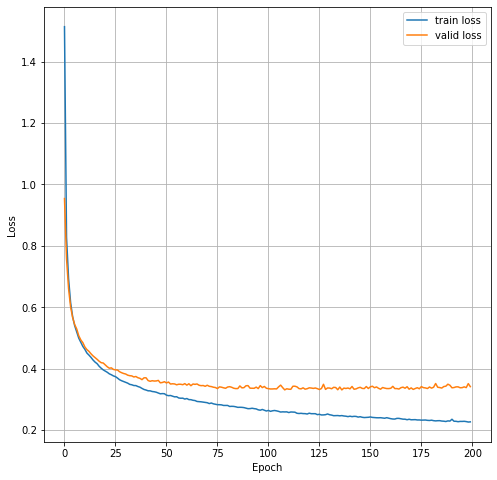

In [141]:
plt.figure(figsize=(8,8))
plt.plot(range(N),loss_train_hist,label='train loss')
plt.plot(range(N),loss_valid_hist,label='valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

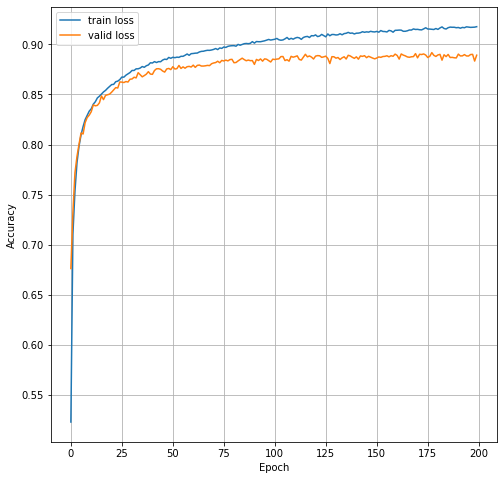

In [142]:
plt.figure(figsize=(8,8))
plt.plot(range(N),acc_train_hist,label='train loss')
plt.plot(range(N),acc_valid_hist,label='valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [143]:
ypred=model(xtest.cuda())

In [144]:
Accuracy(task='multiclass',num_classes=11)(ypred.cpu(),ytest.cpu())

tensor(0.8890)

In [145]:
loss_func(ypred.cpu(),ytest.cpu())

tensor(0.3400, grad_fn=<NllLossBackward0>)

In [146]:
model=RandomForestClassifier(n_estimators=200,criterion='entropy',random_state=42)

In [147]:
model.fit(xtrain,ytrain)

RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=42)

In [148]:
model.score(xtest,ytest)

0.9274594236502153

In [149]:
model.score(xvalid,yvalid)

0.9260455486542443

In [150]:
model.score(xtrain,ytrain)

0.9937292948414577